# RSA

In [1]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from pathlib import Path
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr
from tqdm import tqdm
import seaborn as sns

In [5]:
subj = 'subj001'
subj_date = 'subj001_10062023'
data_path = '../data'
rdm_path = f'{data_path}/interim/PairwiseDecoding/{subj}'
annotation_file = f'{data_path}/raw/annotations/annotations.csv'
preproc_file = f'{data_path}/interim/SIdyads_EEG_pilot/{subj_date}/{subj_date}_preproc.mat'
figure_path = '../reports/figures/RSA'
Path(figure_path).mkdir(exist_ok=True, parents=True)

metric = 'dvw_accuracy'

## Load RDM

The RDMs are saved separately for each iteration (of 20). Load the RDMs and average them. Then plot the average RDM across time. This visualization is a check of the data quality. 

In [6]:
def plot_decoding_rdms(data, figure_path, subj, metric):
    plotting_data = data.groupby('time').mean().reset_index()
    acc = plotting_data[metric].to_numpy()
    time = plotting_data.time.to_numpy()
    ymin, ymax = acc.min()-.01, acc.max()+.01
    print(plotting_data.head())

    _, ax = plt.subplots()
    sns.lineplot(x='time', y=metric, data=plotting_data, ax=ax)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Decoding accuracy')
    ax.vlines(x=[0, 0.5], ymin=ymin, ymax=ymax,
            colors='gray', linestyles='dashed', zorder=0)
    ax.hlines(y=.5, xmin=time.min(), xmax=time.max(),
            colors='gray', linestyles='solid', zorder=0)
    ax.set_xlim([time.min(), time.max()])
    ax.set_ylim([ymin, ymax])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tight_layout()
    plt.savefig(f'{figure_path}/{subj}_decoding-{metric}.png')

In [7]:
def decoding_rdm(rdm_path, figure_path, subj, metric):
    files = sorted(glob(f'{rdm_path}/*.csv.gz'))
    rdm = []
    for f in tqdm(files, total=len(files)):
        rdm.append(pd.read_csv(f))
    rdm = pd.concat(rdm)

    average_rdm = rdm.groupby(['v1', 'v2', 'time']).mean().drop(columns=['perm'])
    plot_decoding_rdms(average_rdm.reset_index(), figure_path, subj, metric)

    reshaped_df = pd.pivot_table(average_rdm, values=metric, index=['v1', 'v2'], columns='time')
    neural_rdms = reshaped_df.to_numpy()
    print(neural_rdms.shape)
    return neural_rdms, average_rdm.reset_index().time.unique()

In [8]:
def correlation_rdm(data_path, subj, preproc_file):
    rdm_path = f'{data_path}/interim/CleanedEEG/{subj}/correlation_rdm.npy'
    neural_rdms = np.load(rdm_path).T

    preproc = loadmat(preproc_file)
    time = preproc['time'].squeeze()
    print(neural_rdms.shape)
    return neural_rdms, time


In [10]:
# if metric == 'correlation':
#     neural_rdms, time = correlation_rdm(data_path, subj, preproc_file)
# else:
#     neural_rdms, time = decoding_rdm(rdm_path, figure_path, subj, metric)

100%|██████████| 20/20 [01:25<00:00,  4.28s/it]
/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_10431/1501693960.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plotting_data = data.groupby('time').mean().reset_index()


    time  accuracy  dvw_accuracy
0 -0.199  0.506612      0.331507
1 -0.194  0.514495      0.338237
2 -0.189  0.502072      0.325132
3 -0.184  0.506697      0.331055
4 -0.179  0.511530      0.330959
(31125, 174)


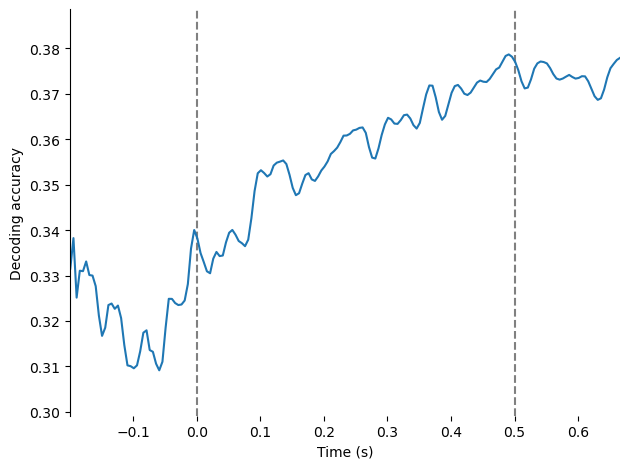

In [11]:
files = sorted(glob(f'{rdm_path}/*.csv.gz'))
rdm = []
for f in tqdm(files, total=len(files)):
    rdm.append(pd.read_csv(f))
rdm = pd.concat(rdm)

average_rdm = rdm.groupby(['v1', 'v2', 'time']).mean().drop(columns=['perm'])
plot_decoding_rdms(average_rdm.reset_index(), figure_path, subj, metric)

reshaped_df = pd.pivot_table(average_rdm, values=metric, index=['v1', 'v2'], columns='time')
neural_rdms = reshaped_df.to_numpy()
print(neural_rdms.shape)

## Feature RDMs

Load the feature annotations and make the RDMs. Care needs to be paid to ensure that that the order of the vidoes across the two RDMs is consistent. 

In [23]:
features_to_exclude = ['dominance', 'cooperation', 'intimacy']
df = pd.read_csv(annotation_file).set_index('video_name')
df = df.drop(columns=features_to_exclude)
df.head()

,indoor,expanse,transitivity,agent distance,facingness,joint action,communication,valence,arousal
video_name,,,,,,,,,
-YwZOeyAQC8_15.mp4,1,0.225,0.895833,0.000000,0.045455,0.700000,0.550,0.650000,0.340909
1AIVH5cEWrI_35.mp4,1,0.250,0.104167,0.075000,1.000000,0.825000,0.900,0.675000,0.340909
2-8-0-2-5-4-8-8-5028025488_7.mp4,1,0.275,1.000000,0.045455,0.050000,0.575000,0.500,0.675000,0.075000
3PJaYWt0cws_5.mp4,0,0.625,1.000000,0.725000,0.340909,0.022727,0.150,0.600000,0.400000
7-5-1-0-3-6-9-8-3775103698_9.mp4,1,0.275,0.925000,0.275000,0.636364,0.750000,0.825,0.722222,0.125000


In [8]:
feature_rdms = {}
for col in df.columns:
    arr = np.expand_dims(df[col].to_numpy(), axis=1)
    feature_rdms[col] = pdist(arr, metric='euclidean')

## Correlate Features and EEG

In [9]:
rsa = {}
for key, val in tqdm(feature_rdms.items()):
    time_corr = np.zeros(neural_rdms.shape[-1])
    for t in range(neural_rdms.shape[-1]):
        time_corr[t], _ = spearmanr(val, neural_rdms[:, t])
    rsa[key] = time_corr

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:13<00:00,  1.47s/it]


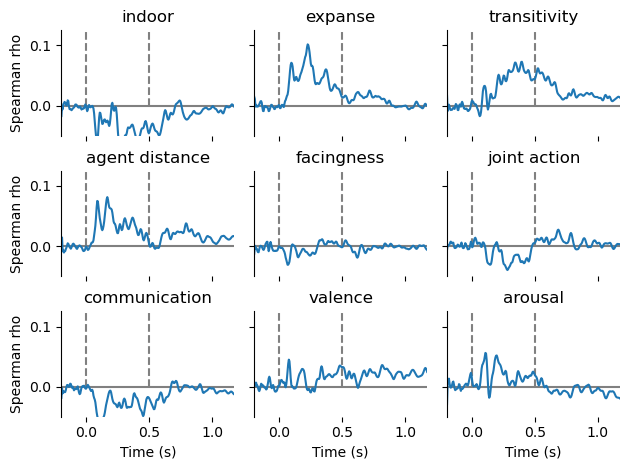

In [10]:
_, axes = plt.subplots(3, 3, sharey=True, sharex=True)
axes = axes.flatten()
ymin, ymax = -.05, .125
for ax, (key, val) in zip(axes, rsa.items()):
    ax.plot(time, val, label=key)
    if key in ['indoor', 'agent distance', 'communication']:
        ax.set_ylabel('Spearman rho')
    if key in ['communication', 'valence', 'arousal']:
        ax.set_xlabel('Time (s)')
    ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
            colors='gray', linestyles='dashed', zorder=0)
    ax.hlines(y=0, xmin=time.min(), xmax=time.max(),
            colors='gray', linestyles='solid', zorder=0)
    ax.set_xlim([time.min(), time.max()])
    ax.set_ylim([ymin, ymax])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title(key)
plt.tight_layout()
plt.savefig(f'{figure_path}/{subj}_rsa-{metric}.png')